In [2]:
# read csv file and clean the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
def read_csv(file_path):
    """
    Read csv file and return a pandas dataframe
    
    Parameters:
    file_path: str, path to the csv file
    
    Returns:
    data: pandas dataframe
    """
    data = pd.read_csv(file_path)
    return data

def decompose(data):
    """
    Decompose the data into different materials
    
    Parameters:
    data: pandas dataframe with columns 'Channel A', 'Channel B', 'Time', 'Temperature'
    
    Returns:
    data_A: pandas dataframe with columns 'Voltage', 'Time', 'Temperature'
    data_B: pandas dataframe with columns 'Voltage', 'Time', 'Temperature'
    """
    data_A = data[['Channel A', 'Time', 'Temperature']]
    data_B = data[['Channel B', 'Time', 'Temperature']]
    
    data_A.columns = ['Voltage', 'Time', 'Temperature']
    data_B.columns = ['Voltage', 'Time', 'Temperature']

    return data_A, data_B

In [4]:
# plot the data
def plot_data(data, title, label_a=False, label_b=False, use_temp=False, show=False):
    if not use_temp:
        if label_a != False:
            plt.plot(data['Time'], data['Channel A'], label=label_a)
        if label_b != False:
            plt.plot(data['Time'], data['Channel B'], label=label_b)
        plt.xlabel('Time (s)')
    else:
        if label_a != False:
            plt.plot(data['Temperature'], data['Channel A'], label=label_a)
        if label_b != False:
            plt.plot(data['Temperature'], data['Channel B'], label=label_b)
        plt.xlabel('Temperature (C)')

    plt.ylabel('Voltage (V)')
    plt.title(title)
    plt.legend()
    if show:
        plt.show()

In [5]:
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def smooth_voltage(data, cutoff, order=5):
    """
    Smooth the voltage data using a butterworth filter
    Parameters:
    data: a pandas dataframe with a Voltage column which should be smoothed
    cutoff: the cutoff frequency (Hz)
    order: the order of the filter (default 5)

    Returns:
    the smoothed data as a pandas dataframe
    """

    # check if the data has a voltage column
    if 'Voltage' not in data.columns:
        raise ValueError('The data does not have a Voltage column')
    
    data_smoothed = data.copy()

    fs = 1.0 / (data_smoothed['Time'][1] - data_smoothed['Time'][0])

    data_smoothed['Voltage'] = butter_lowpass_filter(data['Voltage'], cutoff, fs, order)
    return data_smoothed

def compute_gradient(data, drop_first_last=5000):
    """
    Compute the gradient of the data with respect to temperature
    Parameters:
    data: a pandas dataframe with a Temperature column
    drop_first_last: the number of values to drop from the start and end of the gradient (default 5000)
    
    Returns:
    the gradient of the voltage with respect to temperature
    """

    # check if the data has a Temperature column
    if 'Temperature' not in data.columns:
        raise ValueError('The data does not have a Temperature column')
    
    # check if the data has a Voltage column
    if 'Voltage' not in data.columns:
        raise ValueError('The data does not have a Voltage column')
    
    gradient_column = np.gradient(data['Voltage']) #dV/da
    gradient_temperature = np.gradient(data['Temperature']) #dt/da
    gradient = gradient_column / gradient_temperature
    # replace inf with nan
    #gradient = np.where(gradient == np.inf, np.nan, gradient)
    #gradient = np.where(abs(gradient) >= 0.1, np.nan, gradient)

    # drop the first and last values
    gradient = gradient[drop_first_last:-drop_first_last]

    return gradient

In [6]:
# channel A - type T thermocouple
# channel B - Nickel Copper thermocouple
# heating from -200 to above 0 C
messung_1 = read_csv('data_combined/Messung_1.csv')
Kupfer_Konstantan_low, Kupfer_Nickel_low = decompose(messung_1)

# channel A - type T thermocouple
# channel B - Nickel Copper thermocouple
# cooling from 100 to 0 C
messung_2 = read_csv('data_combined/Messung_2_Dritter_Versuch.csv')
Kupfer_Konstantan_high, Kupfer_Nickel_high = decompose(messung_2)


# channel A - type T thermocouple
# channel B - Nickel Copper thermocouple
# cooling from 100 to = C
# block fell off at some point
messung_2_attempt = read_csv('data_combined/Messung_2.csv')
Kupfer_Konstantan_high_attempt, Kupfer_Nickel_high_attempt = decompose(messung_2_attempt)

# channel A - Copper Graphene thermocouple
messung_3 = read_csv('data_combined/KupferGraphen.csv')
Kupfer_Graphen, _ = decompose(messung_3)

# channel A - Copper Graphite thermocouple
messung_4 = read_csv('data_combined/Messung_4.csv')
Kupfer_Graphit, _ = decompose(messung_4)
Kupfer_Graphit = Kupfer_Graphit.dropna()

# channel A - Graphene Graphite thermocouple
messung_5 = read_csv('data_combined/Messung_5.csv')
Graphen_Graphit, _ = decompose(messung_5)

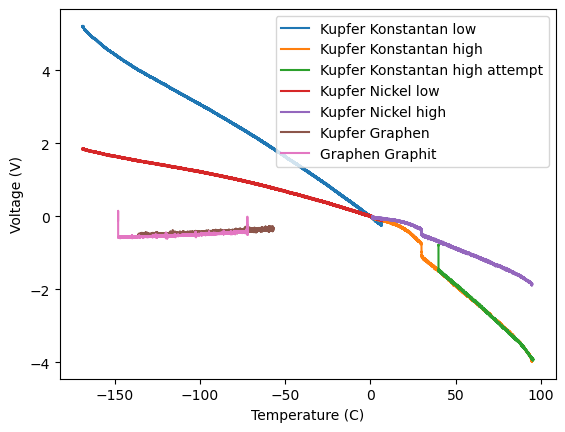

In [7]:
# plot the voltages vs temperature

plt.figure()
plt.plot(Kupfer_Konstantan_low['Temperature'], Kupfer_Konstantan_low['Voltage'], label='Kupfer Konstantan low')
plt.plot(Kupfer_Konstantan_high['Temperature'], Kupfer_Konstantan_high['Voltage'], label='Kupfer Konstantan high')
plt.plot(Kupfer_Konstantan_high_attempt['Temperature'], Kupfer_Konstantan_high_attempt['Voltage'], label='Kupfer Konstantan high attempt')

plt.plot(Kupfer_Nickel_low['Temperature'], Kupfer_Nickel_low['Voltage'], label='Kupfer Nickel low')
plt.plot(Kupfer_Nickel_high['Temperature'], Kupfer_Nickel_high['Voltage'], label='Kupfer Nickel high')

plt.plot(Kupfer_Graphen['Temperature'], Kupfer_Graphen['Voltage'], label='Kupfer Graphen')
#plt.plot(Kupfer_Graphit['Temperature'], Kupfer_Graphit['Voltage'], label='Kupfer Graphit')
plt.plot(Graphen_Graphit['Temperature'], Graphen_Graphit['Voltage'], label='Graphen Graphit')

plt.xlabel('Temperature (C)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

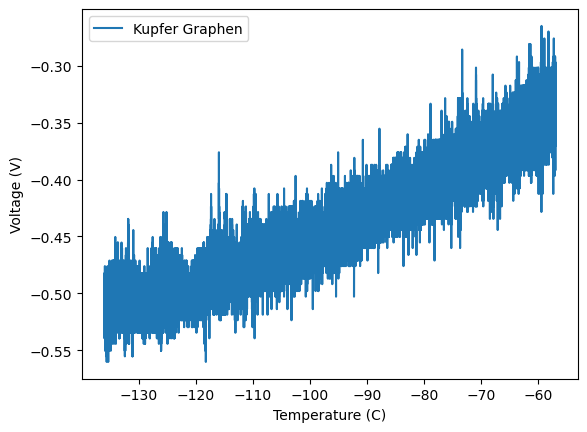

In [8]:
plt.figure()
plt.plot(Kupfer_Graphen['Temperature'], Kupfer_Graphen['Voltage'], label='Kupfer Graphen')
plt.xlabel('Temperature (C)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

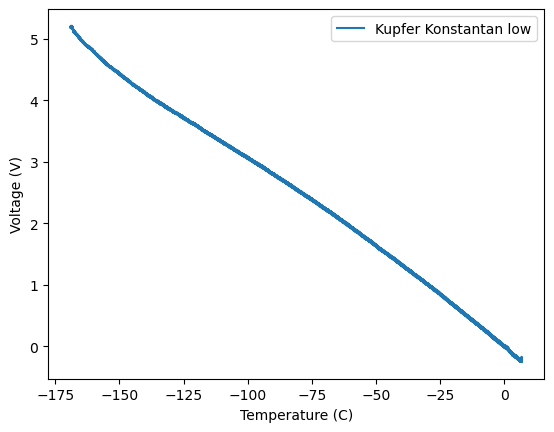

In [9]:
plt.figure()
plt.plot(Kupfer_Konstantan_low['Temperature'], Kupfer_Konstantan_low['Voltage'], label='Kupfer Konstantan low')
plt.xlabel('Temperature (C)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()

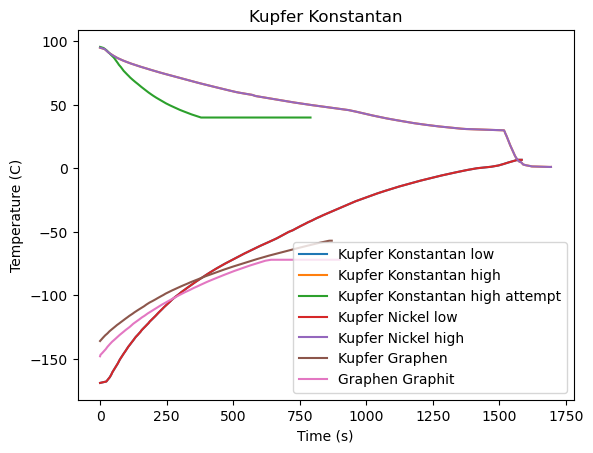

In [265]:
# plot temperature vs time
plt.figure()
plt.plot(Kupfer_Konstantan_low['Time'], Kupfer_Konstantan_low['Temperature'], label='Kupfer Konstantan low')
plt.plot(Kupfer_Konstantan_high['Time'], Kupfer_Konstantan_high['Temperature'], label='Kupfer Konstantan high')
plt.plot(Kupfer_Konstantan_high_attempt['Time'], Kupfer_Konstantan_high_attempt['Temperature'], label='Kupfer Konstantan high attempt')
plt.plot(Kupfer_Nickel_low['Time'], Kupfer_Nickel_low['Temperature'], label='Kupfer Nickel low')
plt.plot(Kupfer_Nickel_high['Time'], Kupfer_Nickel_high['Temperature'], label='Kupfer Nickel high')
plt.plot(Kupfer_Graphen['Time'], Kupfer_Graphen['Temperature'], label='Kupfer Graphen')
#plt.plot(Kupfer_Graphit['Time'], Kupfer_Graphit['Temperature'], label='Kupfer Graphit')
plt.plot(Graphen_Graphit['Time'], Graphen_Graphit['Temperature'], label='Graphen Graphit')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (C)')
plt.title('Kupfer Konstantan')
plt.legend()
plt.show()

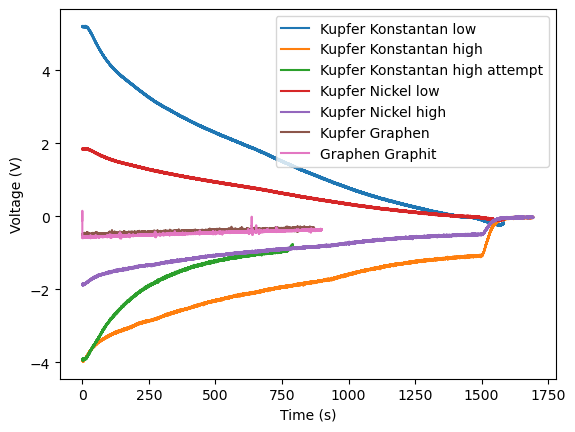

In [267]:
# plot the voltages vs time

plt.figure()
plt.plot(Kupfer_Konstantan_low['Time'], Kupfer_Konstantan_low['Voltage'], label='Kupfer Konstantan low')
plt.plot(Kupfer_Konstantan_high['Time'], Kupfer_Konstantan_high['Voltage'], label='Kupfer Konstantan high')
plt.plot(Kupfer_Konstantan_high_attempt['Time'], Kupfer_Konstantan_high_attempt['Voltage'], label='Kupfer Konstantan high attempt')
plt.plot(Kupfer_Nickel_low['Time'], Kupfer_Nickel_low['Voltage'], label='Kupfer Nickel low')
plt.plot(Kupfer_Nickel_high['Time'], Kupfer_Nickel_high['Voltage'], label='Kupfer Nickel high')
plt.plot(Kupfer_Graphen['Time'], Kupfer_Graphen['Voltage'], label='Kupfer Graphen')
#plt.plot(Kupfer_Graphit['Time'], Kupfer_Graphit['Voltage'], label='Kupfer Graphit')
plt.plot(Graphen_Graphit['Time'], Graphen_Graphit['Voltage'], label='Graphen Graphit')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.show()


/var/folders/5q/chddvdnn39g8dvphqtky5wy00000gn/T/ipykernel_19937/3644231531.py:58: RuntimeWarning: divide by zero encountered in divide
  gradient = gradient_column / gradient_temperature


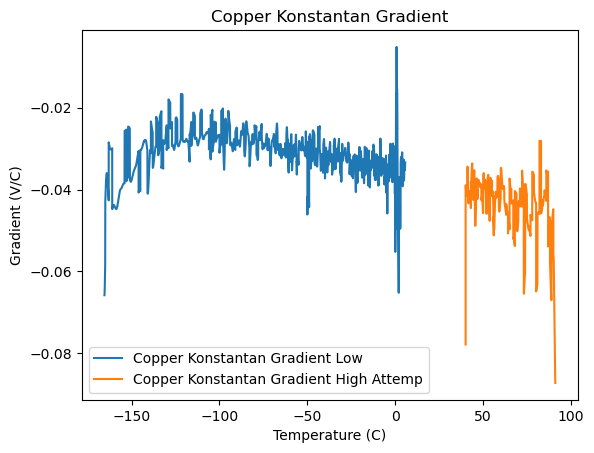

In [231]:
drop_first_last = 5000

# apply the filter
cutoff = 0.1
Kupfer_Konstantan_low_smoothed = smooth_voltage(Kupfer_Konstantan_low, cutoff)
Kupfer_Konstantan_low_gradient = compute_gradient(Kupfer_Konstantan_low_smoothed, drop_first_last)

Kupfer_Konstantan_high_smoothed = smooth_voltage(Kupfer_Konstantan_high, cutoff)
Kupfer_Konstantan_high_gradient = compute_gradient(Kupfer_Konstantan_high_smoothed, drop_first_last)

Kupfer_Konstantan_high_attempt_smoothed = smooth_voltage(Kupfer_Konstantan_high_attempt, cutoff)
Kupfer_Konstantan_high_attempt_gradient = compute_gradient(Kupfer_Konstantan_high_attempt_smoothed, drop_first_last)

# plot the gradient
plt.plot(Kupfer_Konstantan_low_smoothed['Temperature'][drop_first_last:-drop_first_last], Kupfer_Konstantan_low_gradient, label="Copper Konstantan Gradient Low")
#plt.plot(Kupfer_Konstantan_high_smoothed['Temperature'][drop_first_last:-drop_first_last], Kupfer_Konstantan_high_gradient, label="Copper Konstantan Gradient High")
plt.plot(Kupfer_Konstantan_high_attempt_smoothed['Temperature'][drop_first_last:-drop_first_last], Kupfer_Konstantan_high_attempt_gradient, label="Copper Konstantan Gradient High Attemp")
plt.xlabel('Temperature (C)')
plt.ylabel('Gradient (V/C)')
plt.title('Copper Konstantan Gradient')
plt.legend()

# print(copper_konstantan_gradient)

/var/folders/5q/chddvdnn39g8dvphqtky5wy00000gn/T/ipykernel_19937/3644231531.py:58: RuntimeWarning: divide by zero encountered in divide
  gradient = gradient_column / gradient_temperature


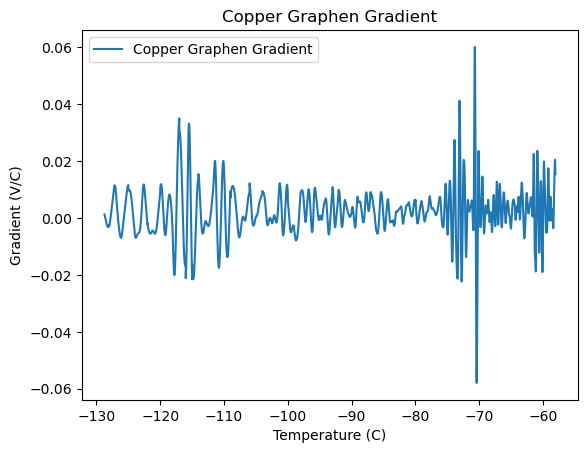

In [272]:
drop_first_last = 5000

# apply the filter
cutoff = 0.1
Kupfer_Graphen_smoothed = smooth_voltage(Kupfer_Graphen, cutoff)
Kupfer_Graphen_gradient = compute_gradient(Kupfer_Graphen_smoothed, drop_first_last)

plt.plot(Kupfer_Graphen_smoothed['Temperature'][drop_first_last:-drop_first_last], Kupfer_Graphen_gradient, label="Copper Graphen Gradient")
plt.xlabel('Temperature (C)')
plt.ylabel('Gradient (V/C)')
plt.title('Copper Graphen Gradient')
plt.legend()

/var/folders/5q/chddvdnn39g8dvphqtky5wy00000gn/T/ipykernel_19937/3644231531.py:58: RuntimeWarning: divide by zero encountered in divide
  gradient = gradient_column / gradient_temperature


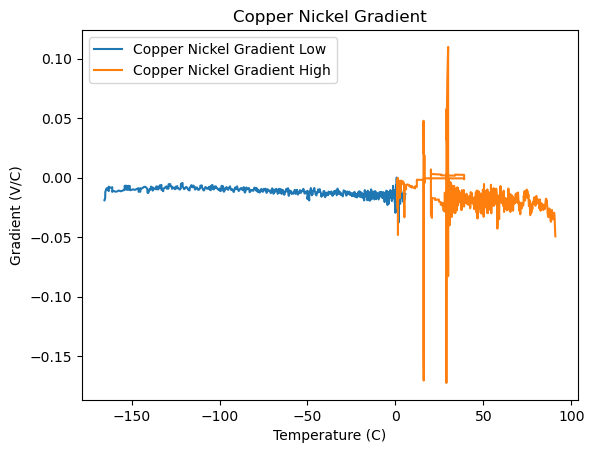

In [175]:
drop_first_last = 5000

# apply the filter
cutoff = 0.1
Kupfer_Nickel_low_smoothed = smooth_voltage(Kupfer_Nickel_low, cutoff)
Kupfer_Nickel_low_gradient = compute_gradient(Kupfer_Nickel_low_smoothed, drop_first_last)

Kupfer_Nickel_high_smoothed = smooth_voltage(Kupfer_Nickel_high, cutoff)
Kupfer_Nickel_high_gradient = compute_gradient(Kupfer_Nickel_high_smoothed, drop_first_last)


# plot the gradient
plt.plot(Kupfer_Nickel_low_smoothed['Temperature'][drop_first_last:-drop_first_last], Kupfer_Nickel_low_gradient, label="Copper Nickel Gradient Low")
plt.plot(Kupfer_Nickel_high_smoothed['Temperature'][drop_first_last:-drop_first_last], Kupfer_Nickel_high_gradient, label="Copper Nickel Gradient High")
plt.xlabel('Temperature (C)')
plt.ylabel('Gradient (V/C)')
plt.title('Copper Nickel Gradient')
plt.legend()